## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [6]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from alfi.datasets import P53Data
from alfi.configuration import VariationalConfiguration
from alfi.models import OrdinaryLFM, TrainMode, generate_multioutput_gp
from alfi.plot import Plotter1d, Colours, tight_kwargs
from alfi.trainers import VariationalTrainer, PreEstimator

Let's start by importing our dataset...

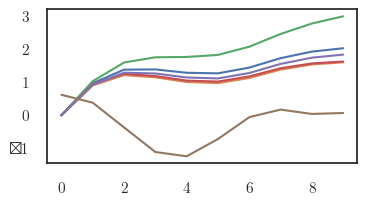

In [11]:
from alfi.datasets import ToyTranscriptomicGenerator

dataset = ToyTranscriptomicGenerator(
    5, 1, softplus=True)
dataset.generate_single()#basal_rate, sensitivity, decay_rate, lengthscale=lengthscale)
# ground_truths = P53Data.params_ground_truth()
class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        # with torch.no_grad():
        #     sens = torch.tensor(1.)
        #     dec = torch.tensor(0.8)
        #     self.model.raw_sensitivity[3] = self.model.positivity.inverse_transform(sens)
        #     self.model.raw_decay[3] = self.model.positivity.inverse_transform(dec)
        super().after_epoch()

num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])
plt.plot(dataset.f_observed[0, 0])
t_end = dataset.t_observed[-1]

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [12]:
from alfi.utilities import softplus
from torch import softmax
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(
            self.positivity.inverse_transform(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_basal = Parameter(
            self.positivity.inverse_transform(0.1 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_sensitivity = Parameter(
            self.positivity.inverse_transform(2*torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))

    def nonlinearity(self, f):
        return softplus(f)

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.latent_gp
        if not (self.train_mode == TrainMode.GRADIENT_MATCH):
            f = f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh

In [13]:
config = VariationalConfiguration(
    num_samples=80,
    initial_conditions=False
)

num_inducing = 20  # (I x m x 1)
inducing_points = torch.linspace(0, t_end, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, t_end+2, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True

print('hi')

hi


In [16]:
track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
print(dataset)
from torch import multiprocessing

In [26]:
from docs.notebooks.nonlinear.temp_data import Data
from alfi.datasets import LFMDataset

dataset = ToyTranscriptomicGenerator(
    5, 1, softplus=True)
dataset.generate_single()


data = Data()
data.m_observed = dataset.m_observed
data.t_observed = dataset.t_observed
data.f_observed = dataset.f_observed
data._data = dataset._data
data.data = dataset.data
torch.save(data, './test_dataset.pt')

[(tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000]), tensor([0.0000, 0.2829, 0.5574, 0.7965, 1.0148, 1.2511, 1.4313, 1.4746, 1.5019,
        1.6771], dtype=torch.float64)), (tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000]), tensor([0.0000, 0.3845, 0.8063, 1.2253, 1.6423, 2.0936, 2.5000, 2.7532, 2.9564,
        3.2979], dtype=torch.float64)), (tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000]), tensor([0.0000, 0.3957, 0.7480, 1.0419, 1.2995, 1.5652, 1.7682, 1.8281, 1.8663,
        2.0504], dtype=torch.float64)), (tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000]), tensor([0.0000, 0.4055, 0.8004, 1.1561, 1.4842, 1.8260, 2.1074, 2.2361, 2.3273,
        2.5601], dtype=torch.float64)), (tensor([0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000, 8.0000,
        9.0000]), tensor([0.0000, 0.2867, 

/Users/jacob/proj/alfi/alfi/datasets/toy.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(ref.basal, dtype=self.dtype)
/Users/jacob/proj/alfi/alfi/datasets/toy.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decay = torch.tensor(ref.decay, dtype=self.dtype)
/Users/jacob/proj/alfi/alfi/datasets/toy.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensitivity = torch.tensor(ref.sensitivity, dtype=self.dtype)


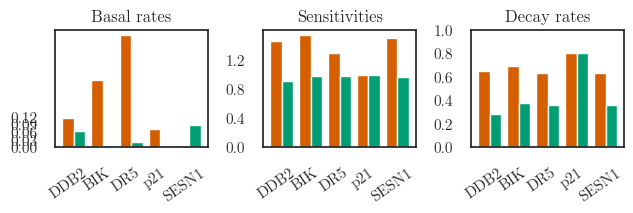

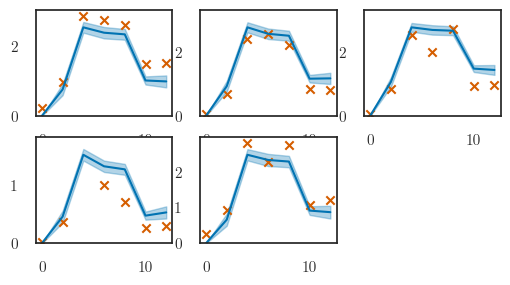

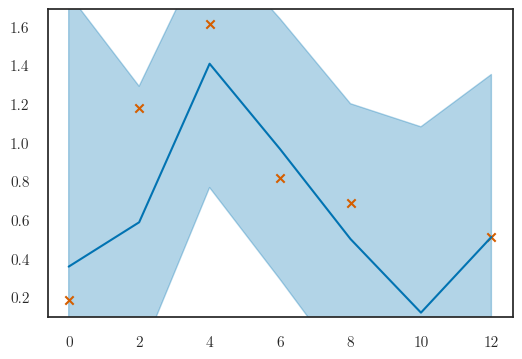

In [31]:
plotter = Plotter1d(lfm, dataset.gene_names, style='seaborn')

t_predict = torch.linspace(0, t_end, 7, dtype=torch.float32)

# plotter.plot_losses(trainer, last_x=200)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)


titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics,
                        ground_truths=P53Data.params_ground_truth(),
                        titles=titles,
                        figsize=(6.5, 2.3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])


plt.tight_layout()
# plt.savefig('./kinetics.pdf', **tight_kwargs)

plotter.plot_gp(q_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
out_f = plotter.plot_gp(q_f, t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.f_observed, transform=softplus)


In [32]:
torch.save(out_f.loc, '/Users/jacob/proj/gskproj/var_out_f.loc.pt')
torch.save(out_f.covariance_matrix, '/Users/jacob/proj/gskproj/var_out_f.covariance.pt')
